In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

In [9]:
def collect_data_and_plot(df, test_mode, setting_name, n_stores):
    # Filter the dataframe for the specified number of stores
    df = df[df['# of stores'] == n_stores]
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'],
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/one_warehouse_real/{n_stores}/{row['Architecture Class']}/{row['store_underage_cost']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 24:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 4096
        batch_size = 4096
        num_batches = n_samples // batch_size
        num_steps = 500
        start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        avg_s_underage.append(relevant_data['s_underage_costs'].mean() / row['store_underage_cost'])
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / row['store_underage_cost'])
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / row['store_underage_cost'])
        avg_cost.append(relevant_data['s_underage_costs'].sum() * n_stores + relevant_data['s_holding_costs'].sum() * n_stores + relevant_data['w_holding_costs'].sum())

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding 
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Calculate relative cost
    # Calculate cost as percentage of lowest cost
    # Calculate min cost for each underage cost
    df['cost'] = df.groupby('store_underage_cost')['avg_cost'].transform(lambda x: x/x.min() * 100)

    plot_data = df.pivot(index="store_underage_cost", columns='Architecture Class', 
                         values=['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Cost (% of minimum at each underage cost)', 'Store lost sales / (average unit underage cost)', 'Store Holding Cost / (average unit underage cost)', 'Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    x_values = store_underage_cost
    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}', 
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Average unit underage cost')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


   store_underage_cost  # of stores                         Architecture Class  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %                                                                                                                                                                                                                                                      path
0                    3            1  One_Store_And_One_Warehouse_For_Warehouse    3.321822  3.319493   3.319863         12         0.0  /user/ml4723/Prj/NIC/ray_results/store_disruption_independent_store_debug/run_2024-11-30_11-44-29/run_5e42f_00004_4_learning_rate=0.0010,omit_context_from_store_input=True,samples=2,store_orders_for_warehouse=False,store_underag_2024-11-30_11-44-29
1                    6            1  One_Store_And_One_Warehouse_For_Warehouse    4.563836  4.565439   4.564831         12         0.0  /user/ml4723/Prj/NIC/ray_results/store_disruption_independent_store_debug/run_2024-11-30_11-48

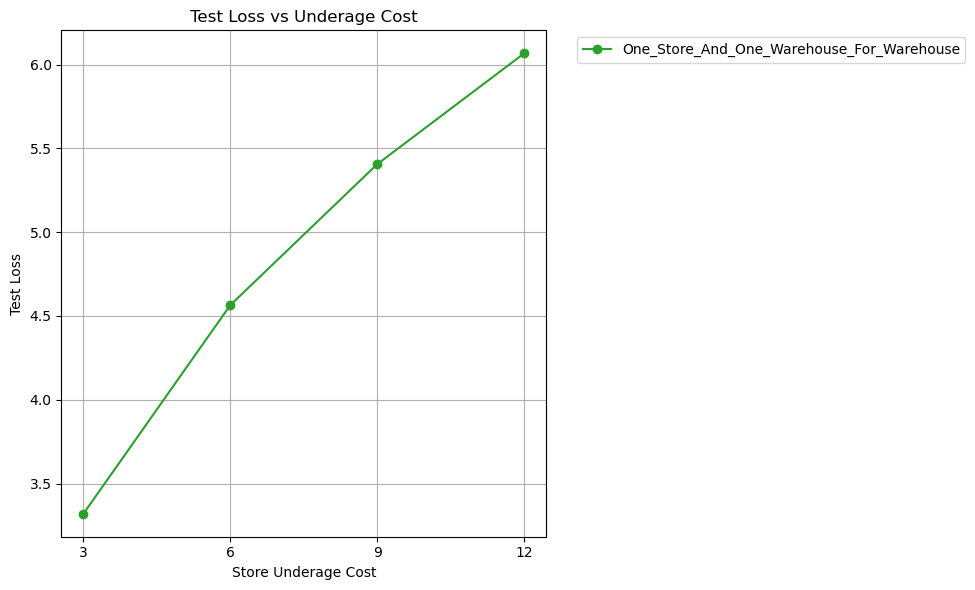

In [3]:
# Define color scheme for architecture types
color_scheme = {
    "One_Store_And_One_Warehouse_For_Warehouse": "#2ca02c",  # Green
}

linestyle_scheme = {
    "One_Store_And_One_Warehouse_For_Warehouse": "-",  # Solid
}

path = 'store_disruption_independent_store_debug'
store_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'omit_context_from_store_input':
        return False
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

store_underage_cost = [3, 6, 9, 12]
results_interpretor = rri.RayResultsinterpreter()

# One store for warehouse
df_store = results_interpretor.make_table(store_paths, 
    {'store_underage_cost': store_underage_cost,}, 
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_store.insert(1, 'Architecture Class', "One_Store_And_One_Warehouse_For_Warehouse")
df_store.insert(1, 'hyperparam_name', "symmetry_aware")

# Combine dataframes
df = df_store.copy()

min_test_loss = df.groupby(['store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate'], inplace=True)

print(df_to_print.to_string())

# Create the plot for fixed case
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Test Loss - handle duplicate entries by taking mean
pivot_df_fixed_test = df.groupby(['store_underage_cost', 'Architecture Class'])['Test Loss'].mean().unstack()

for column in pivot_df_fixed_test.columns:
    ax.plot(pivot_df_fixed_test.index, pivot_df_fixed_test[column], 
            marker='o', 
            label=column, 
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Test Loss')
ax.set_title('Test Loss vs Underage Cost')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_xticks(pivot_df_fixed_test.index)

plt.tight_layout()
plt.show()

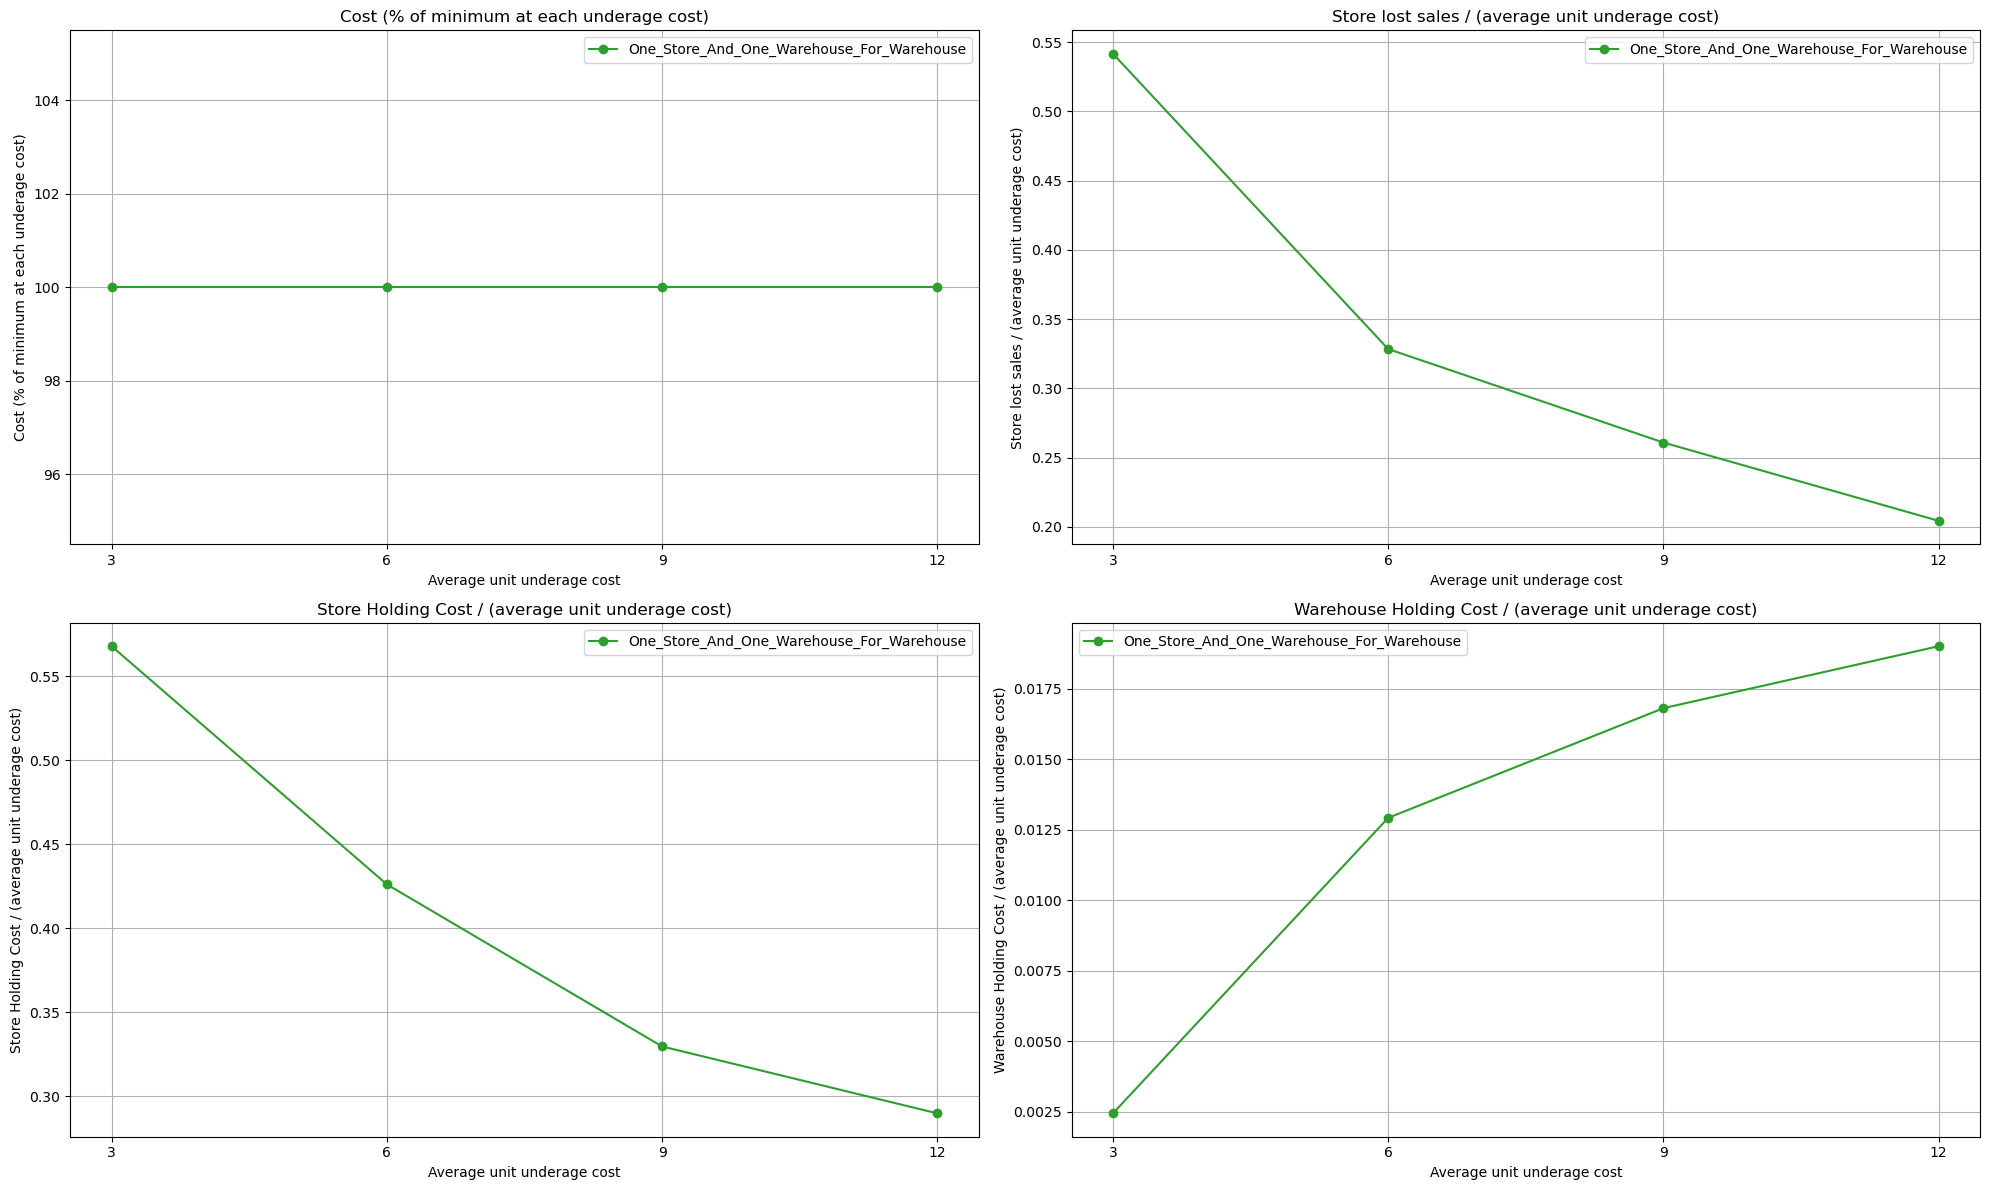

In [29]:
df_t = collect_data_and_plot(df, "test", "one_warehouse_lost_demand_random_yield_independent_store_debug", 1)

In [13]:
# Define color scheme for architecture types
color_scheme = {
    "Decentralized_store_orders_for_warehouse": "#1f77b4",  # Blue
    "Decentralized_WC": "#1f77b4",  # Blue 
    "Symmetry_Aware_store_orders_for_warehouse": "#9467bd",  # Purple
    "Symmetry_Aware": "#9467bd",  # Purple
    "Decentralized_Independent_Store_WC": "#2ca02c",  # Green
}

linestyle_scheme = {
    "Decentralized_store_orders_for_warehouse": "-",  # Solid
    "Decentralized_WC": "--",  # Dashed
    "Symmetry_Aware_store_orders_for_warehouse": "-",  # Solid
    "Symmetry_Aware": "--",  # Dashed
    "Decentralized_Independent_Store_WC": "-",  # Solid
}

path = 'store_disruption'
decentralized_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized/10'
}
symmetry_aware_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/symmetry_aware/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/symmetry_aware/10'
}
decentralized_independent_store_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized_independent_store/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized_independent_store/10'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_orders_for_warehouse':
        return False
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

store_underage_cost = [3, 6, 9, 12]
results_interpretor = rri.RayResultsinterpreter()

# Decentralized with store orders for warehouse
df_decentralized_store_orders = results_interpretor.make_table(decentralized_paths,
    {'store_underage_cost': store_underage_cost, 'store_orders_for_warehouse': True},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_decentralized_store_orders.insert(2, 'Architecture Class', "Decentralized_store_orders_for_warehouse")
df_decentralized_store_orders.insert(1, 'hyperparam_name', "decentralized")

# Decentralized without context
df_decentralized_wc = results_interpretor.make_table(symmetry_aware_paths,
    {'store_underage_cost': store_underage_cost, 'store_orders_for_warehouse': False, 'omit_context_from_store_input': True},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_decentralized_wc.insert(2, 'Architecture Class', "Decentralized_WC")
df_decentralized_wc.insert(1, 'hyperparam_name', "symmetry_aware")

# Decentralized Independent Store
df_decentralized_independent_store = results_interpretor.make_table(decentralized_independent_store_paths,
    {'store_underage_cost': store_underage_cost},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_decentralized_independent_store.insert(2, 'Architecture Class', "Decentralized_Independent_Store_WC")
df_decentralized_independent_store.insert(1, 'hyperparam_name', "decentralized_independent_store")

# Symmetry aware with store orders for warehouse
df_symmetry_aware_store_orders = results_interpretor.make_table(symmetry_aware_paths,
    {'store_underage_cost': store_underage_cost, 'store_orders_for_warehouse': True, 'omit_context_from_store_input': False},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware_store_orders.insert(2, 'Architecture Class', "Symmetry_Aware_store_orders_for_warehouse")
df_symmetry_aware_store_orders.insert(1, 'hyperparam_name', "symmetry_aware")

# Basic Symmetry aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {'store_underage_cost': store_underage_cost, 'store_orders_for_warehouse': False, 'omit_context_from_store_input': False},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "Symmetry_Aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# Combine dataframes
df = pd.concat([
    df_decentralized_store_orders,
    df_decentralized_wc,
    df_decentralized_independent_store,
    df_symmetry_aware_store_orders,
    df_symmetry_aware
])

min_test_loss = df.groupby(['# of stores', 'store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'store_underage_cost'], inplace=True)

cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_print = df.copy()
df_to_print.drop(columns=['Learning Rate', 'hyperparam_name', 'path', 'store_orders_for_warehouse', 'omit_context_from_store_input'], inplace=True)
print(df_to_print.to_string())

# Create subplots for each n_stores
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(right=0.92) # Reduce right margin to bring legend closer
n_stores_values = [3, 10]  # Updated n_stores values

# Create empty lists to store lines for legend
lines = []
labels = []

for idx, n_stores in enumerate(n_stores_values):
    # Filter data for current n_stores
    df_filtered = df[df['# of stores'] == n_stores]
    
    # Create pivot table for current n_stores
    pivot_df = df_filtered.groupby(['store_underage_cost', 'Architecture Class'])['Test Gap %'].mean().unstack()
    
    # Plot on current subplot
    ax = axes[idx]
    for column in pivot_df.columns:
        line = ax.plot(pivot_df.index, pivot_df[column],
                marker='o',
                color=color_scheme[column],
                linestyle=linestyle_scheme[column])
        if idx == 0:  # Only store legend info from first subplot
            lines.append(line[0])
            labels.append(column)
    
    ax.set_xlabel('Store Underage Cost')
    ax.set_ylabel('Test Gap %')
    ax.set_title(f'Test Gap % vs Underage Cost (n_stores={n_stores})')
    ax.grid(True)
    ax.set_xticks(pivot_df.index)

# Add single legend to the right of all subplots with reduced spacing
fig.legend(lines, labels, bbox_to_anchor=(0.94, 0.5), loc='center left')

plt.show()

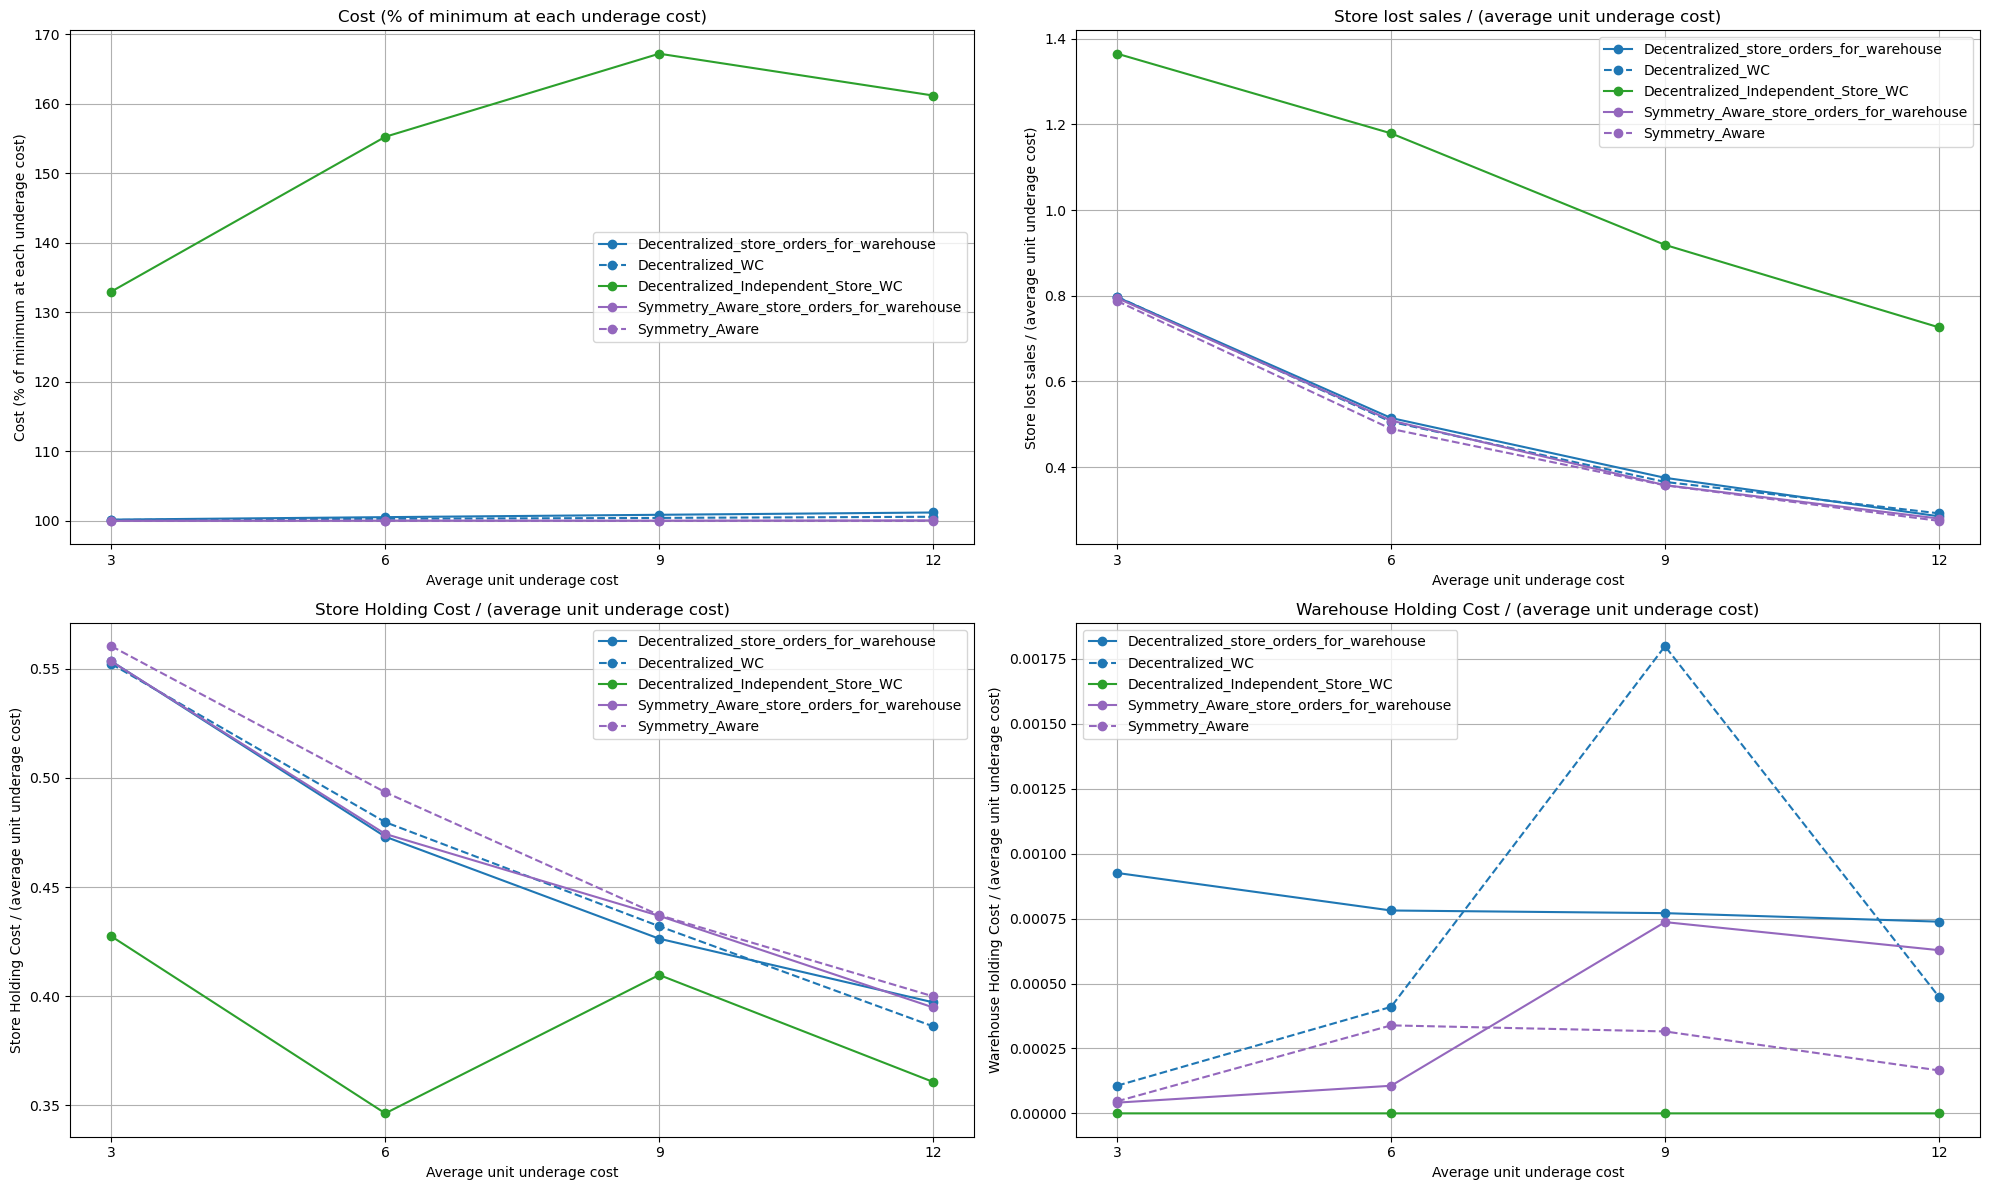

In [11]:
df_t = collect_data_and_plot(df, "test", "one_warehouse_lost_demand._random_yield", 3)